Test of cellpose cell segmentation works for low-res IMC panorama.

In [1]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

import cv2
import skimage
import scipy.ndimage, scipy.stats

In [2]:
from cellpose import models

In [12]:
data_dir = "/mnt/central_nas/users/ychian/Exp/test"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/test/20250204_QH_MALDI_OPS_SRIMC_test_panorama.tif',
 '/mnt/central_nas/users/ychian/Exp/test/20250204_QH_MALDI_OPS_SRIMC_test_panorama_cropped.tif',
 '/mnt/central_nas/users/ychian/Exp/test/20250204_QH_MALDI_OPS_SRIMC_test_panorama_processed.tif']

(469, 469)


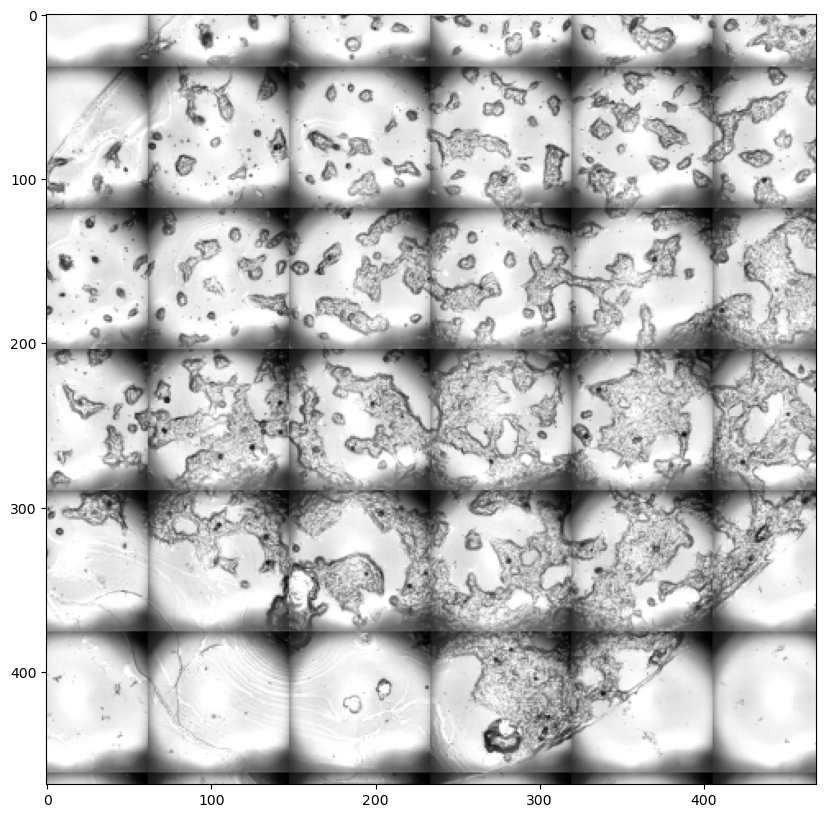

In [21]:
file = files[1]

img = tif.imread(file)
# comvert to gray
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = img.astype(np.uint8)
print(img.shape)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

In [152]:
def gaussian_notch_filter(shape, centers, sigma=2):
    """Create a Gaussian notch reject filter mask with high selectivity."""
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    mask = np.ones((rows, cols), dtype=np.float32)

    for cx, cy in centers:
        dx, dy = x - cx, y - cy
        d = dx**2 + dy**2
        gaussian = 1 - np.exp(-d / (2 * sigma**2))
        mask *= gaussian

    return mask

def remove_specific_periodicity(img, periodicity_px, sigma, overtone_max, apply_diagonals=True):
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Get offset of target frequency in pixels
    offset_r = int(round((1 / periodicity_px) * (rows)))
    offset_c = int(round((1 / periodicity_px) * (cols)))
    
    notch_coords = []
    # Build list of target frequency coordinates
    for overtone in range(1, overtone_max+1):
        offset_rm = int(round(overtone/periodicity_px * (rows)))
        offset_cm = int(round(overtone/periodicity_px * (cols)))
        notch_coords += [
            (ccol + offset_cm, crow),
            (ccol - offset_cm, crow),
            (ccol, crow + offset_rm),
            (ccol, crow - offset_rm)
        ]
        if apply_diagonals:
            if overtone == 1:
                notch_coords += [
                    (ccol + offset_cm, crow + offset_rm),
                    (ccol - offset_cm, crow - offset_rm),
                    (ccol + offset_cm, crow - offset_rm),
                    (ccol - offset_cm, crow + offset_rm)
                ]
            else:
                notch_coords += [
                    (ccol + offset_cm, crow + offset_rm),
                    (ccol - offset_cm, crow - offset_rm),
                    (ccol + offset_cm, crow - offset_rm),
                    (ccol - offset_cm, crow + offset_rm),
                    (ccol + offset_cm, crow + offset_r),
                    (ccol + offset_cm, crow - offset_r),
                    (ccol - offset_cm, crow + offset_r),
                    (ccol - offset_cm, crow - offset_r),
                    (ccol + offset_r, crow + offset_cm),
                    (ccol - offset_r, crow + offset_cm),
                    (ccol + offset_r, crow - offset_cm),
                    (ccol - offset_r, crow - offset_cm)
                ]
            
    print("Notch coordinates:", notch_coords)
    # Build Gaussian notch mask
    mask = gaussian_notch_filter((rows, cols), notch_coords, sigma=sigma)

    # Apply mask and inverse FFT
    f_filtered = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(f_filtered))
    img_back = np.abs(img_back)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back, mask

# Example usage
result_img, used_mask = remove_specific_periodicity(
    img,
    periodicity_px=86,
    sigma=2,
    overtone_max=100,
    apply_diagonals=True
)



Notch coordinates: [(239, 234), (229, 234), (234, 239), (234, 229), (239, 239), (229, 229), (239, 229), (229, 239), (245, 234), (223, 234), (234, 245), (234, 223), (245, 245), (223, 223), (245, 223), (223, 245), (245, 239), (245, 229), (223, 239), (223, 229), (239, 245), (229, 245), (239, 223), (229, 223), (250, 234), (218, 234), (234, 250), (234, 218), (250, 250), (218, 218), (250, 218), (218, 250), (250, 239), (250, 229), (218, 239), (218, 229), (239, 250), (229, 250), (239, 218), (229, 218), (256, 234), (212, 234), (234, 256), (234, 212), (256, 256), (212, 212), (256, 212), (212, 256), (256, 239), (256, 229), (212, 239), (212, 229), (239, 256), (229, 256), (239, 212), (229, 212), (261, 234), (207, 234), (234, 261), (234, 207), (261, 261), (207, 207), (261, 207), (207, 261), (261, 239), (261, 229), (207, 239), (207, 229), (239, 261), (229, 261), (239, 207), (229, 207), (267, 234), (201, 234), (234, 267), (234, 201), (267, 267), (201, 201), (267, 201), (201, 267), (267, 239), (267, 22

In [148]:
# save result
# out_file = os.path.join(data_dir, os.path.basename(file).replace('.tif', '_filtered.tif'))
# tif.imwrite(out_file, result_img)

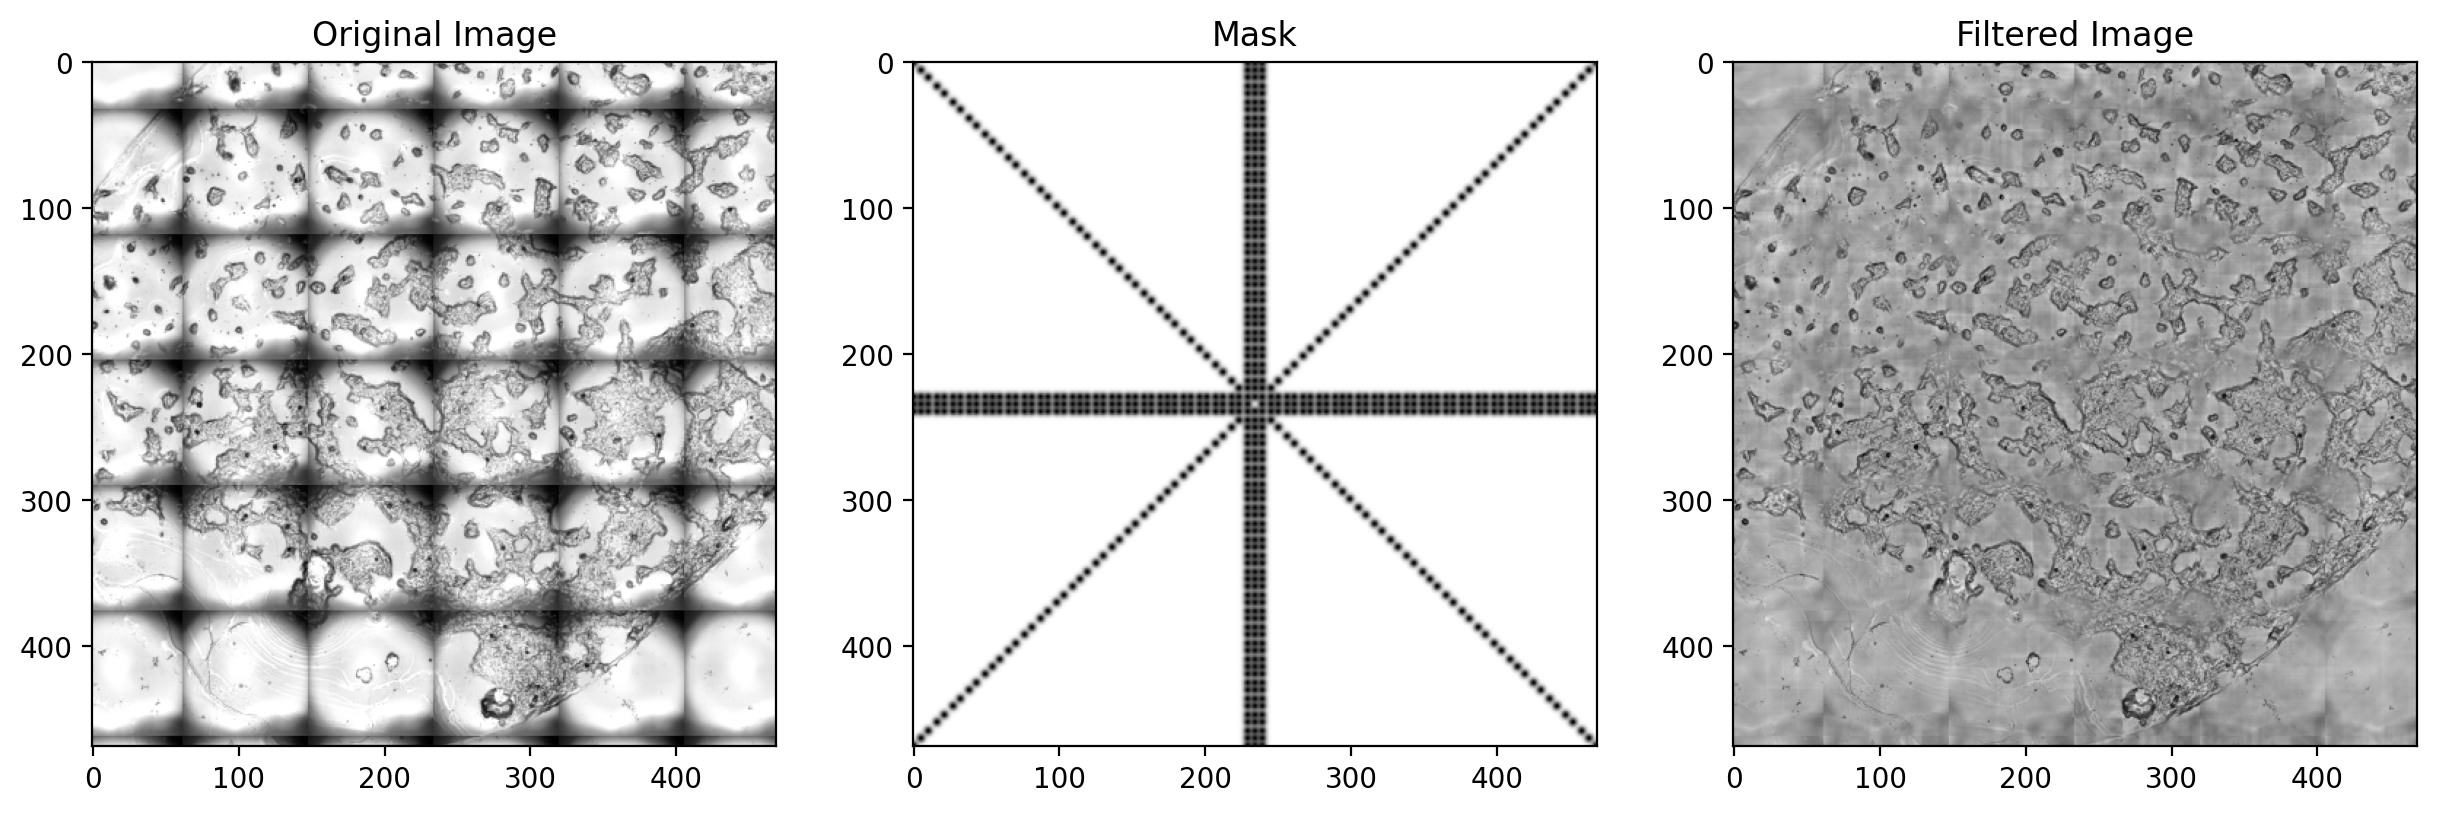

In [153]:
plt.figure(figsize=(15, 7), dpi=200)
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
# plt.colorbar()
plt.subplot(132)
plt.imshow(used_mask, cmap='gray')
# plt.xlim(img.shape[1]//2-100, img.shape[1]//2+100)
# plt.ylim(img.shape[0]//2-100, img.shape[0]//2+100)
plt.title('Mask')
plt.subplot(133)
plt.imshow(result_img, cmap='gray')
plt.title('Filtered Image')
# plt.colorbar()
plt.show()

In [165]:
model = models.Cellpose(model_type="cyto3")

channels = [[0, 0]]

masks, flows, styles, diams = model.eval(result_img, diameter=None, channels = channels, normalize=True)

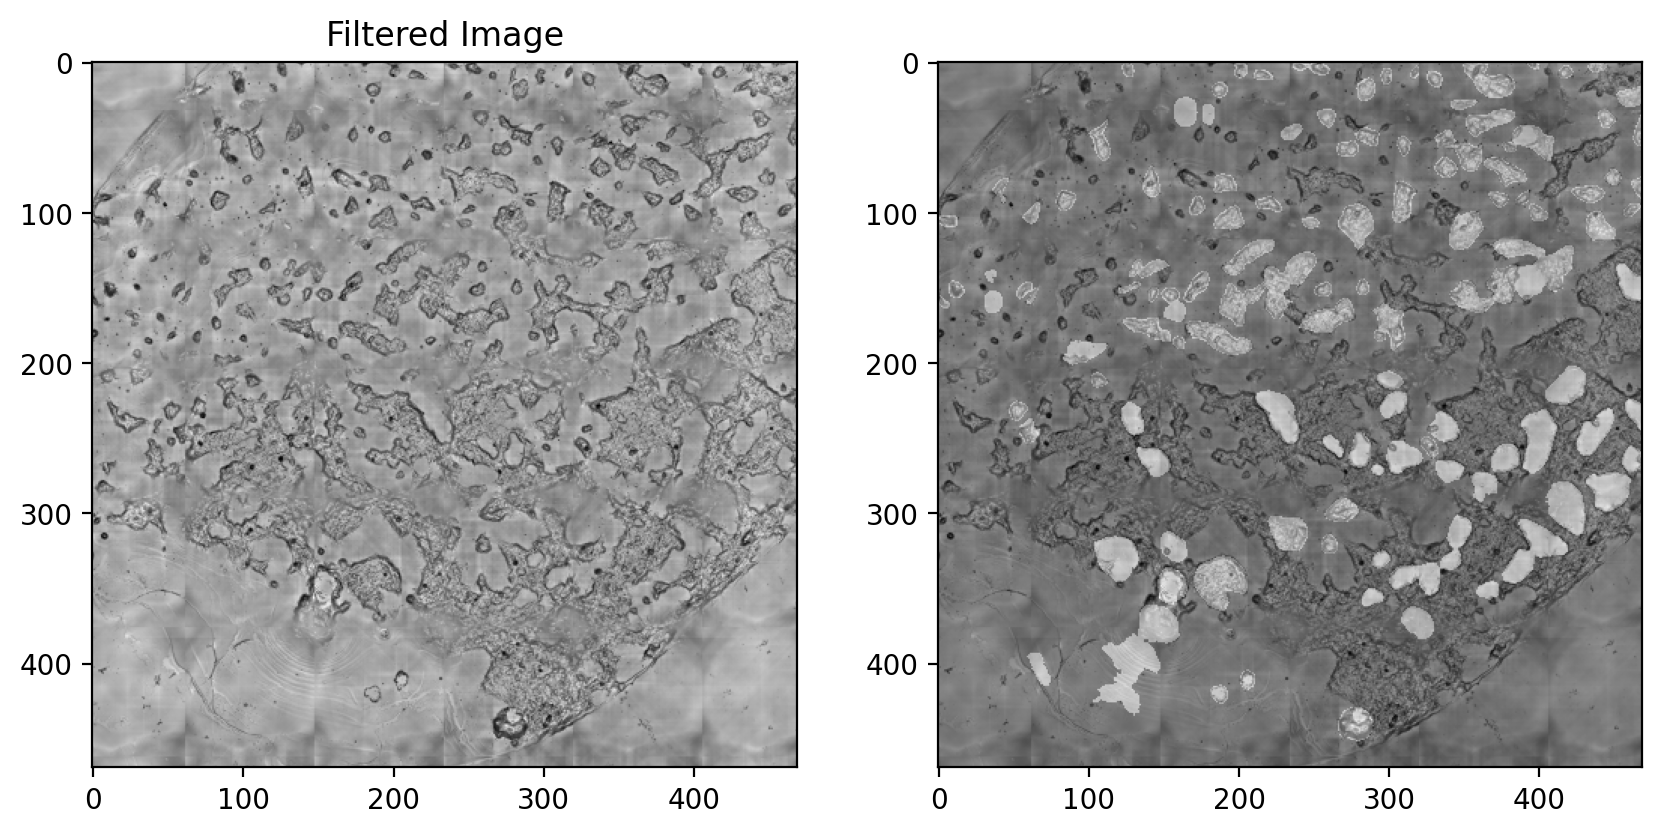

In [168]:
plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(121)
plt.imshow(result_img, cmap='gray')
plt.title('Filtered Image')
plt.subplot(122)
plt.imshow(0.5*result_img + 50*(masks > 0), cmap='gray')
plt.show()